run this notebook with the `gayles` conda environment

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyC')

In [3]:
# generate enzyme perturbation data
ant ='../../models/Antimony/TopologyC.ant'  
# util.generate_data(ant, [0.5, 1.5], '')

In [4]:
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.9044426622520472e-14

In [5]:
pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x', '0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [6]:
data_file05 = '../../data/interim/generated_data/topologyC_1/TopologyC_0.5.csv'
data_file15 = '../../data/interim/generated_data/topologyC_1/TopologyC_1.5.csv'


In [7]:
BMCA_obj05 = antemll.antemll(ant, data_file05, cobra_sbml='../../models/sbml/TopologyC_cobra.xml')
BMCA_obj15 = antemll.antemll(ant, data_file15, cobra_sbml='../../models/sbml/TopologyC_cobra.xml')


../../models/Antimony/TopologyC_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_cobra.ant


No objective coefficients in model. Unclear what should be optimized


## Running ADVI

In [10]:
def run_prior_predictive(BMCA_obj):
    ll = emll.LinLogLeastNorm(BMCA_obj.N, BMCA_obj.Ex.to_numpy(), BMCA_obj.Ey.to_numpy(), BMCA_obj.v_star, driver='gelsy')
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', emll.util.initialize_elasticity(BMCA_obj.Ex.to_numpy().T, 'Ex', b=0.05, sd=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', emll.util.initialize_elasticity(BMCA_obj.Ey.to_numpy().T, 'Ey', b=0.05, sd=1, alpha=5))

        trace_prior = pm.sample_prior_predictive()

    return trace_prior

In [11]:
prior05 = run_prior_predictive(BMCA_obj05)
prior15 = run_prior_predictive(BMCA_obj15)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [8]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 100000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 46,697


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 40,890


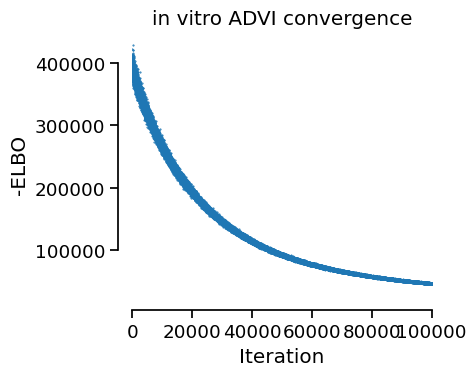

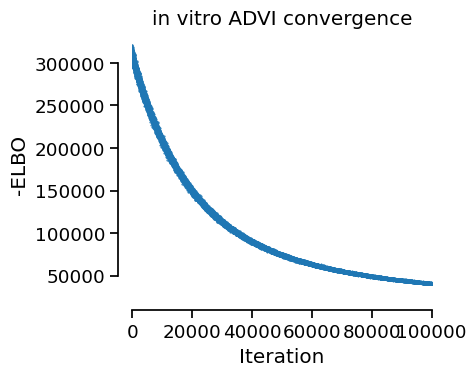

In [9]:
trace05 = run_ADVI(BMCA_obj05)
trace15 = run_ADVI(BMCA_obj15)

In [11]:
with gzip.open("topologyC_allData_traces-5-15.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace05":trace05,
                "trace15":trace15,
                },
                f,
            )

In [ ]:
trace01 = run_ADVI(BMCA_obj01)
trace02 = run_ADVI(BMCA_obj02)
trace03 = run_ADVI(BMCA_obj03)
trace04 = run_ADVI(BMCA_obj04)

trace3 = run_ADVI(BMCA_obj3)
trace5 = run_ADVI(BMCA_obj5)
trace7 = run_ADVI(BMCA_obj7)
trace100 = run_ADVI(BMCA_obj100)

In [ ]:
with gzip.open("topologyC_allData_traces-remaining.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,

                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100
                },
                f,
            )

## Analysis

In [12]:
picklefolder = '../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyC_allData_traces-5-15.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [13]:
trace05=traces['trace05']
trace15=traces['trace15']


In [14]:
Ex05_advi = util.get_az_summary(trace05)
Ex15_advi = util.get_az_summary(trace15)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [ ]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                Ex05_advi, Ex15_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA_allData_elasticities.csv')

In [15]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

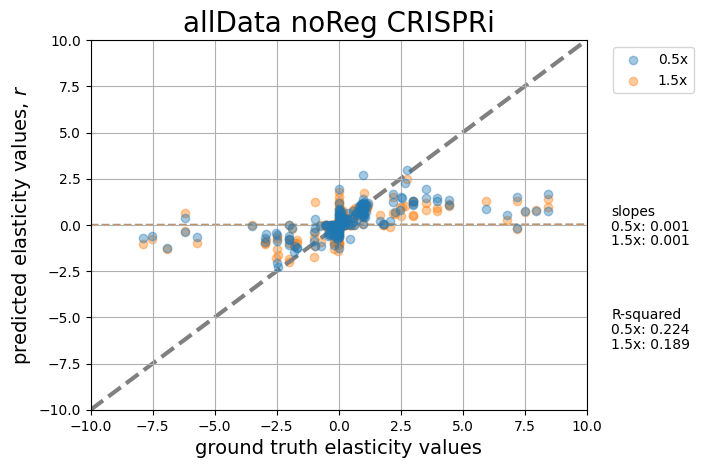

In [15]:
# plt.axes().set_aspect('equal', 'datalim')

plt.ylim(-10,10)
plt.xlim(-10,10)

plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData noReg CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 11
line_spacing = 0.8
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(2):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)


In [16]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()
MAE.to_csv('topologyC_allData_MAE.csv')

In [17]:
MAE

gt          0.000000
0.5x    12434.703111
1.5x    12446.295214
dtype: float64

## Calculating FCCs

In [16]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [17]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


## Negative predictions

In [18]:
Ex05_prior = util.get_az_summary(prior05['prior']['Ex'])
Ex15_prior = util.get_az_summary(prior15['prior']['Ex'])


arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [19]:
priorFCC05 = estimate_CCs(BMCA_obj05, Ex05_prior.reshape((68,-1)))
priorFCC15 = estimate_CCs(BMCA_obj15, Ex15_prior.reshape((68,-1)))

postFCC05 = estimate_CCs(BMCA_obj05, Ex05_advi.reshape((68,-1)))
postFCC15 = estimate_CCs(BMCA_obj15, Ex15_advi.reshape((68,-1)))

In [20]:
prior_FCCs = [priorFCC05, priorFCC15]
post_FCCs = [postFCC05, postFCC15]


In [21]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_priorFCCs = pd.concat([append_FCC_df(prior_FCCs[i], pt_labels[i]) for i in range(len(prior_FCCs))])
prd_postFCCs = pd.concat([append_FCC_df(post_FCCs[i], pt_labels[i]) for i in range(len(post_FCCs))])

In [20]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
medPrdFCCs.head()

,,vPGI,vPFK,vFBA,vTPI,vGDH,vPGK,vGPM,vENO,vPYK,vZWF,...,vNDHII,vGROWTH,vATP_MAINTENANCE,vXCH_GLC,vPIT,vXCH_P,vXCH_ACE1,v_ACE_OUT,vXCH_ACE2,vGL6P_HYDROLYSIS
pt_rxn,pt_str,,,,,,,,,,,,,,,,,,,,,
vPGI,0.5x,-1.942383,0.060086,-0.004408,-0.007406,-0.004743,0.001058,0.045626,0.044006,0.081219,-0.074455,...,-0.025658,-0.033502,0.014880,0.057671,-0.025320,-0.006504,0.010718,-0.008636,-0.002082,-1.410746e-08
vPFK,0.5x,0.031761,-1.968222,0.001607,-0.000436,0.012906,0.005780,0.040117,0.034637,0.054114,-0.043164,...,-0.010469,-0.019120,0.011083,0.056493,-0.008567,-0.001665,0.007775,-0.006019,-0.001756,-8.541569e-09
vFBA,0.5x,0.031798,0.031410,-1.998153,-0.000234,0.013383,0.006005,0.040548,0.034968,0.054343,-0.043175,...,-0.010451,-0.019181,0.011288,0.056458,-0.008451,-0.001635,0.007763,-0.006010,-0.001752,-8.540431e-09
vTPI,0.5x,0.031798,0.031410,0.001847,-2.000234,0.013383,0.006005,0.040548,0.034968,0.054343,-0.043175,...,-0.010451,-0.019181,0.011288,0.056458,-0.008451,-0.001635,0.007763,-0.006010,-0.001752,-8.540431e-09
vGDH,0.5x,0.015408,0.020399,0.001379,-0.001520,-1.988754,0.003235,0.029239,0.023232,0.034336,-0.021080,...,-0.005440,-0.014809,0.005657,0.057245,-0.003860,-0.000324,0.006036,-0.004553,-0.001483,-4.206839e-09


## Evaluating FCC ranking

In [22]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['v_ACE_OUT']

In [24]:
def calculate_FCC_med_rankings(postFCC, reaction='v_ACE_OUT'):
    postFCC_med=pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    m1 = postFCC_med.index.values[:, None] == postFCC_med.columns.values
    postFCC = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=postFCC_med.columns, index=postFCC_med.index)
    postFCC_rankings= postFCC.rank(axis=1, ascending=False, na_option='keep')
    
    return postFCC_rankings.loc[reaction]
    

### via Spearman rank coefficients

In [24]:
from scipy.stats import spearmanr

def bootstrap_spearman(x, y, num_bootstrap=1000, alpha=0.05):
    n = len(x)
    corr_list = []

    # Original Spearman correlation
    corr_original, p_value = spearmanr(x, y)

    for _ in range(num_bootstrap):
        # Generate bootstrap samples
        indices = np.random.randint(0, n, n)
        x_bootstrap = [x[i] for i in indices]
        y_bootstrap = [y[i] for i in indices]

        # Calculate Spearman correlation for the bootstrap sample
        corr, _ = spearmanr(x_bootstrap, y_bootstrap)
        corr_list.append(corr)

    # Convert to numpy array for convenience
    corr_list = np.array(corr_list)
    
    # Calculate the confidence intervals
    lower_bound = np.percentile(corr_list, (alpha/2) * 100)
    upper_bound = np.percentile(corr_list, (1 - alpha/2) * 100)
    
    return corr_original, p_value, lower_bound, upper_bound

In [25]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in rxn_FCCs:
    b = calculate_FCC_med_rankings(FCC)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [35]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in rxn_FCCs:
    b = calculate_FCC_med_rankings(FCC)
    b_list.append(b)

    aa = a.dropna().sort_values().iloc[0:10]
    bb = b_list[0].dropna().sort_values().iloc[0:10]

    spearman_r, p_value, lower_ci, upper_ci = bootstrap_spearman(aa, bb)
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [36]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.5x,1.0,6.646897e-64,1.0,1.0
1.5x,1.0,6.646897e-64,1.0,1.0


In [29]:
spearman_df.to_csv('topologyC_allData_spr.csv')

In [30]:
plt.bar(pt_labels, [i[0] for i in spearman_coefficients], alpha=0.5, color='r')
plt.grid()

for i, txt in enumerate([i[1].round(3) for i in spearman_coefficients]):
    plt.annotate(txt, (pt_labels[i], [i[0] for i in spearman_coefficients][i]), ha='center')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

IndexError: invalid index to scalar variable.

### evaluating top 10 rankings

In [26]:
pt_labels= ['0.5x-pr', '1.5x-pr', '0.5x-post', '1.5x-post']

In [27]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = calculate_FCC_med_rankings(FCC)
    b_list.append(b)

ranked_b_list = [b.sort_values().reset_index().set_index('v_ACE_OUT') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('v_ACE_OUT')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q

,gt,0.5x-pr,1.5x-pr,0.5x-post,1.5x-post
v_ACE_OUT,,,,,
1.0,vACS,vATP_syn,vXCH_ACE2,vXCH_ACE1,vGLT
2.0,vGLT,vPNT_req,vATP_MAINTENANCE,vATP_MAINTENANCE,vACS
3.0,vACK,vATP_MAINTENANCE,vXCH_ACE1,vGLT,vXCH_ACE1
4.0,vGLC_feed,vCYTBO,vACS,vACS,vPTA
5.0,vATP_MAINTENANCE,vPGK,vCYTBO,vGLC_feed,vACK
...,...,...,...,...,...
64.0,vGL6P_HYDROLYSIS,vEDA,vACEK_2,vS7P_R5P_TKT,vACN_1
65.0,vPTS_4,vFBP,vPPS,vPPS,vPPS
66.0,vPTS_3,vPPS,vFBP,vFBP,vFBP


In [29]:
q.to_csv('topologyC_allData-v_rankings.csv')

#### Counts of top ten ranked FCCs

In [33]:
rank_df = pd.read_csv('topologyC_allData-v_rankings.csv')

In [34]:
topTen_df = rank_df[rank_df['v_ACE_OUT'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results

,0.5x-pr,1.5x-pr,0.5x-post,1.5x-post
0,3,5,7,6


In [35]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)

Int64Index([15, 18, 22, 32, 40, 49, 61], dtype='int64')
Int64Index([22, 33, 42, 43, 60], dtype='int64')
Int64Index([33, 43, 48], dtype='int64')
Int64Index([33, 38, 42, 43], dtype='int64')
